In [1]:
!pip install datasets

In [2]:
from huggingface_hub import list_datasets

all_dataset = list(list_datasets())  # convert generator to list
print(f"Total number of datasets: {len(all_dataset)}")
print(f"First 10 datasets: {all_dataset[:10]}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Total number of datasets: 398733
First 10 datasets: [DatasetInfo(id='openbmb/Ultra-FineWeb', author='openbmb', sha='36a6465a6c39d944c73940ee6c584cce99d5f841', created_at=datetime.datetime(2025, 3, 6, 5, 11, 34, tzinfo=datetime.timezone.utc), last_modified=datetime.datetime(2025, 5, 9, 2, 12, 8, tzinfo=datetime.timezone.utc), private=False, gated=False, disabled=False, downloads=10374, downloads_all_time=None, likes=100, paperswithcode_id=None, tags=['task_categories:text-generation', 'language:en', 'language:zh', 'size_categories:n>1T', 'arxiv:2505.05427', 'arxiv:2412.04315', 'region:us'], trending_score=65, card_data=None, siblings=None, xet_enabled=None), DatasetInfo(id='nvidia/OpenCodeReasoning', author='nvidia', sha='20a1ca19c0d050fe9057fc08339d6b370ec1c67a', created_at=datetime.datetime(2025, 4, 1, 20, 7, 48, tzinfo=datetime.timezone.utc), last_modified=datetime.datetime(2025, 5, 4, 23, 54, 22, tzinfo=datetime.timezone.utc), private=False, gated=False, disabled=False, downloads=13

In [3]:
!pip install -U datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 16.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pla

In [4]:
# !pip install -U fsspec


In [5]:
from datasets import load_dataset  # not load_datasets

emotions = load_dataset("emotion")
print(emotions)


HTTP Error 429 thrown while requesting HEAD https://huggingface.co/datasets/emotion/resolve/main/README.md
Retrying in 1s [Retry 1/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/datasets/emotion/resolve/main/README.md
Retrying in 2s [Retry 2/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/datasets/emotion/resolve/main/README.md
Retrying in 4s [Retry 3/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/datasets/emotion/resolve/main/README.md
Retrying in 8s [Retry 4/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/datasets/emotion/resolve/main/README.md
Retrying in 8s [Retry 5/5].


README.md:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})


In [6]:
train_ds = emotions['train']
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [7]:
len(train_ds)

16000

In [8]:
 train_ds.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

In [9]:
train_ds['text'][:5]

['i didnt feel humiliated',
 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'im grabbing a minute to post i feel greedy wrong',
 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
 'i am feeling grouchy']

In [10]:
train_ds = emotions['train']
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [11]:
len(train_ds)

16000

In [12]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [13]:
train_ds.column_names

['text', 'label']

In [14]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [15]:
print(train_ds[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}


In [16]:
print(train_ds['text'][:5])

['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy']


#What if my dataset is not on the hub

In [17]:
dataset_url = "https://huggingface.co/datasets/transformersbook/emotion-train-split/raw/main/train.txt"
!wget {dataset_url}

--2025-05-21 10:13:50--  https://huggingface.co/datasets/transformersbook/emotion-train-split/raw/main/train.txt
Resolving huggingface.co (huggingface.co)... 3.166.152.44, 3.166.152.105, 3.166.152.110, ...
Connecting to huggingface.co (huggingface.co)|3.166.152.44|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1658616 (1.6M) [text/plain]
Saving to: ‘train.txt’

train.txt           100%[===================>]   1.58M  --.-KB/s    in 0.1s    

2025-05-21 10:13:50 (14.9 MB/s) - ‘train.txt’ saved [1658616/1658616]



In [18]:
!head -n 3 train.txt

i didnt feel humiliated;sadness
i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake;sadness
im grabbing a minute to post i feel greedy wrong;anger


In [19]:
emotions_local = load_dataset('csv', data_files='train.txt', sep = ';', names = ['text', 'label'])

Generating train split: 0 examples [00:00, ? examples/s]

In [20]:
emotions_local = load_dataset('csv', data_files = 'train.txt', sep = ';', names = ['text', 'label'])

In [21]:
# simpler
dataset_url = "https://huggingface.co/datasets/transformersbook/emotion-train-split/raw/main/train.txt"
emotions_remote = load_dataset("csv", data_files=dataset_url, sep=";",
                               names=["text", "label"])

Generating train split: 0 examples [00:00, ? examples/s]

#From datasets to DataFrames

In [22]:
import pandas as pd

emotions.set_format(type = 'pandas')

df = emotions['train'][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [23]:
def label_int2str(row):
    return emotions['train'].features['label'].int2str(row)

df['label_name'] = df['label'].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


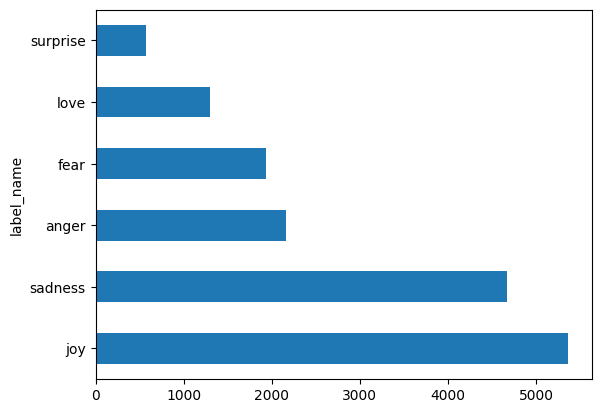

In [24]:
import matplotlib.pyplot as plt

df['label_name'].value_counts().plot.barh()
plt.show()

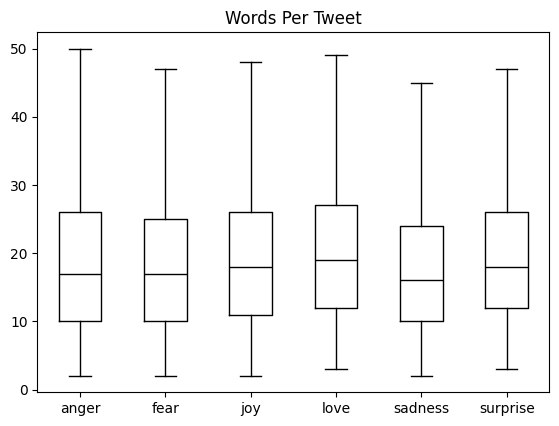

In [25]:
df['Words Per Tweet'] = df['text'].str.split().apply(len)
df.boxplot('Words Per Tweet', by = 'label_name', grid = False, showfliers = False, color = 'black')
plt.suptitle('')
plt.xlabel('')
plt.show()

In [26]:
emotions.reset_format()

In [27]:
import pandas as pd

emotions.set_format(type = 'pandas')
df = emotions['train'][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [28]:
def label_int2str(row):
    return emotions['train'].features['label'].int2str(row)


df['label_name'] = df['label'].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


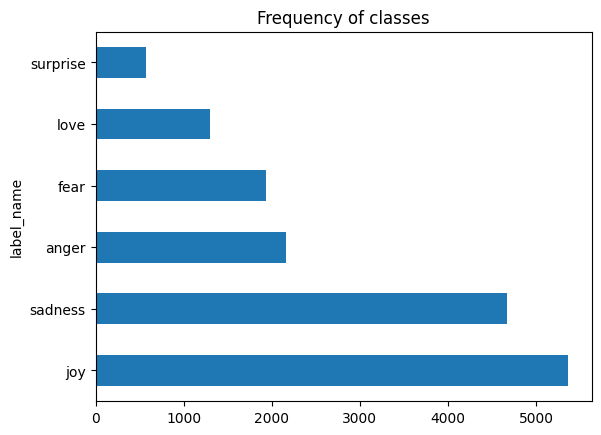

In [29]:
import matplotlib.pyplot as plt

df['label_name'].value_counts().plot.barh()
plt.title('Frequency of classes')
plt.show()

#How long are our tweets

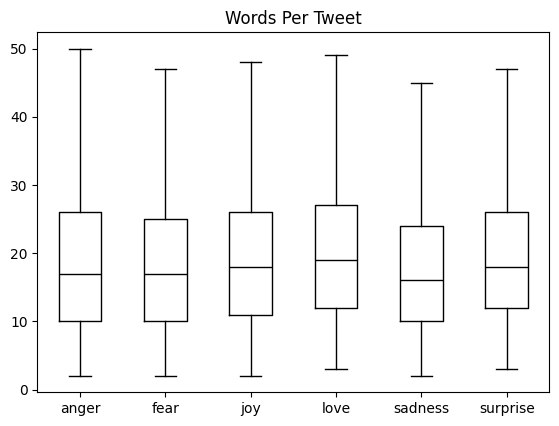

In [30]:
df['Words Per Tweet'] = df['text'].str.split().apply(len)
df.boxplot('Words Per Tweet', by = 'label_name', grid = False, showfliers = False, color = 'black')
plt.suptitle('')
plt.xlabel('')
plt.show()

In [31]:
emotions.reset_format()

#From text to tokens

#Character Tokenization

In [32]:
text = 'Tokenizing text is a core task of NLP.'
tokenized_text = list(text)
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P', '.']


In [33]:
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9, 'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18, 'z': 19}


In [34]:
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9, 'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18, 'z': 19}


In [35]:
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7, 14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]


In [36]:
# import torch
# import torch.nn.functional as F

# input_ids = torch.tensor(input_ids)
# one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))
# one_hot_encodings.shape

In [37]:
import tensorflow as tf

input_ids = tf.constant(input_ids)
one_hot_encodings = tf.one_hot(input_ids, len(token2idx))
print(one_hot_encodings.shape)

(38, 20)


In [38]:
print(f"Token: {tokenized_text[0]}")
print(f"Tensor index: {input_ids[0]}")
print(f"One-hot: {one_hot_encodings[0]}")

Token: T
Tensor index: 5
One-hot: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


#Word tokenization

In [39]:
tokenized_text = text.split()
print(tokenized_text)

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']


#Subword Tokenization

In [40]:
from transformers import AutoTokenizer

model_ckpt = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [41]:
#Same but more specific
from transformers import DistilBertTokenizer
distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)

In [42]:
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [43]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


In [44]:
tokenizer.convert_tokens_to_string(tokens)

'[CLS] tokenizing text is a core task of nlp. [SEP]'

In [45]:
tokenizer.vocab_size

30522

In [46]:
tokenizer.model_max_length

512

In [47]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

#Tokenizing the whole dataset

In [48]:
def tokenize(batch):
    return tokenizer(batch['text'], padding = True, truncation = True)

In [49]:
print(tokenize(emotions['train'][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [50]:
emotions_encoded = emotions.map(tokenize, batched = True, batch_size = None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

#Transformers as feature extractors

In [51]:
from transformers import AutoModel
import torch

model_ckpt = 'distilbert-base-uncased'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AutoModel.from_pretrained(model_ckpt).to(device)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [52]:
text = 'this is a test'
inputs = tokenizer(text, return_tensors = 'pt')
print(inputs)

{'input_ids': tensor([[ 101, 2023, 2003, 1037, 3231,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}


In [53]:
inputs = {k: v.to(device) for k, v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)

print(outputs.last_hidden_state.size())

torch.Size([1, 6, 768])


In [54]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

In [55]:
tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

['[CLS]', 'this', 'is', 'a', 'test', '[SEP]']

In [56]:
outputs.last_hidden_state[:, 0].size()

torch.Size([1, 768])

In [57]:
def extract_hidden_states(batch):
    inputs = {k: v.to(device) for k, v in batch.items()
                                if k in tokenizer.model_input_names}
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    return {'hidden_states': last_hidden_state[:, 0].cpu().numpy()}

In [58]:
emotions_encoded.set_format('torch', columns = ['input_ids', 'attention_mask', 'label'])

In [59]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched = True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [60]:
emotions_hidden['train'][0]

{'label': tensor(0),
 'input_ids': tensor([  101,  1045,  2134,  2102,  2514, 26608,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0

In [61]:
import numpy as np

X_train = np.array(emotions_hidden['train']['hidden_states'])
X_valid = np.array(emotions_hidden['validation']['hidden_states'])
y_train = np.array(emotions_hidden['train']['label'])
y_valid = np.array(emotions_hidden['validation']['label'])

#Visualizing the training data

In [62]:
import matplotlib.pyplot as plt
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

X_scaled = MinMaxScaler().fit_transform(X_train)
mapper = UMAP(n_components = 2, metric = 'cosine').fit(X_scaled)

df_emb = pd.DataFrame(mapper.embedding_, columns = ['X', 'Y'])
df_emb['label'] = y_train
df_emb.head()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,X,Y,label
0,4.731185,3.567515,0
1,-2.773201,3.997857,0
2,5.608436,7.112744,3
3,-2.109727,6.005132,2
4,-3.059583,5.773461,3


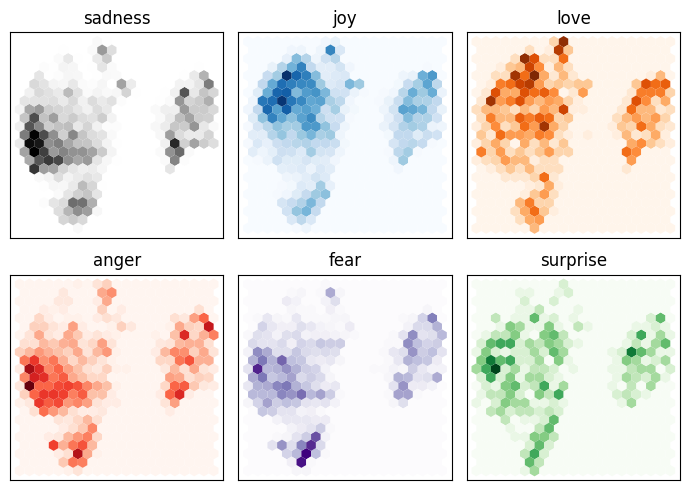

In [63]:
fig, ax = plt.subplots(2, 3, figsize = (7, 5))
ax = ax.flatten()
cmaps = ['Greys', 'Blues', 'Oranges', 'Reds', 'Purples', 'Greens']
labels = emotions['train'].features['label']
for i, (label, cmap) in enumerate(zip(labels.names, cmaps)):
    df_emb_sub = df_emb.query(f'label == {i}')
    ax[i].hexbin(df_emb_sub['X'], df_emb_sub['Y'], cmap = cmap,
                 gridsize = 20, linewidths = (0,))
    ax[i].set_title(label)
    ax[i].set_xticks([]), ax[i].set_yticks([])

plt.tight_layout()
plt.show()

#Training a simple classifier

In [64]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter = 3000)
lr_clf.fit(X_train, y_train)

LogisticRegression(max_iter=3000)

In [65]:
lr_clf.score(X_valid, y_valid)

0.6345

In [66]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy = 'most_frequent')
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

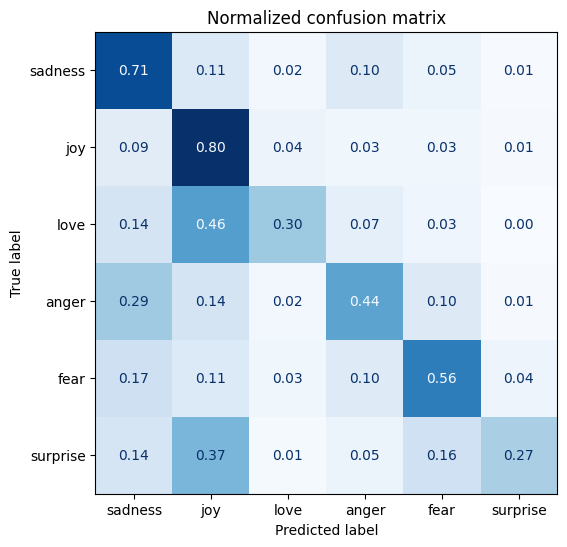

In [67]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize = 'true')
    fig, ax = plt.subplots(figsize = (6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)
    disp.plot(cmap = 'Blues', values_format = '.2f', ax = ax, colorbar = False)
    plt.title('Normalized confusion matrix')
    plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels.names)

# Fine-tuning Transformers

In [68]:
from transformers import AutoModelForSequenceClassification

model_ckpt = 'distilbert-base-uncased'
num_labels = 6
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt,
                                                           num_labels = num_labels).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [69]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average = 'weighted')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1}

In [70]:
from huggingface_hub import notebook_login

notebook_login()

In [73]:
from transformers import TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded['train']) // batch_size
model_name = f'{model_ckpt}-finetuned-emotion'
training_args = TrainingArguments(
    output_dir = model_name,
    num_train_epochs = 2,
    learning_rate = 2e-5,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    weight_decay = 0.01,
    eval_strategy = 'epoch',
    disable_tqdm = False,
    logging_steps = logging_steps,
    push_to_hub = True
)

In [74]:
from transformers import Trainer

trainer = Trainer(
    model = model,
    args = training_args,
    compute_metrics = compute_metrics,
    train_dataset = emotions_encoded['train'],
    eval_dataset = emotions_encoded['validation'],
    tokenizer = tokenizer
)

trainer.train()

<ipython-input-74-ef3c3f8f9c73>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: rustam-skilledin to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.793500,0.296546,0.914000,0.913624
2,0.238500,0.209370,0.926000,0.925890


TrainOutput(global_step=500, training_loss=0.5160067825317383, metrics={'train_runtime': 396.9294, 'train_samples_per_second': 80.619, 'train_steps_per_second': 1.26, 'total_flos': 720342861696000.0, 'train_loss': 0.5160067825317383, 'epoch': 2.0})

In [75]:
preds_output = trainer.predict(emotions_encoded['validation'])

In [77]:
preds_output.metrics

{'test_loss': 0.20936954021453857,
 'test_accuracy': 0.926,
 'test_f1': 0.9258904812957838,
 'test_runtime': 4.2312,
 'test_samples_per_second': 472.681,
 'test_steps_per_second': 7.563}

In [80]:
y_preds = np.argmax(preds_output.predictions, axis = 1)

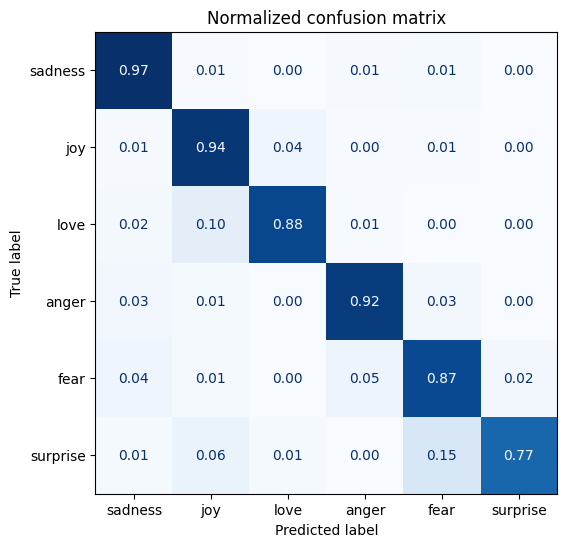

In [81]:
plot_confusion_matrix(y_preds, y_valid, labels.names)

#Fine Tuning with Keras

In [81]:
from transformers import TFAutoModelForSequenceClassification

tf_model = (TFAutoModelForSequenceClassification
            .from_pretrained(model_ckpt, num_labels=num_labels))

In [82]:
tokenizer_columns = tokenizer.model_input_names

tf_train_dataset = emotions_encoded["train"].to_tf_dataset(
    columns=tokenizer_columns, label_cols=["label"], shuffle=True,
    batch_size=batch_size)
tf_eval_dataset = emotions_encoded["validation"].to_tf_dataset(
    columns=tokenizer_columns, label_cols=["label"], shuffle=False,
    batch_size=batch_size)

/usr/local/lib/python3.11/dist-packages/datasets/arrow_dataset.py:400: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [83]:
import tensorflow as tf

tf_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.metrics.SparseCategoricalAccuracy())

tf_model.fit(tf_train_dataset, validation_data=tf_eval_dataset, epochs=2)

Epoch 1/2
250/250 [==============================] - 159s 530ms/step - loss: 0.5284 - sparse_categorical_accuracy: 0.8152 - val_loss: 0.2024 - val_sparse_categorical_accuracy: 0.9250
Epoch 2/2
250/250 [==============================] - 131s 524ms/step - loss: 0.1416 - sparse_categorical_accuracy: 0.9396 - val_loss: 0.1416 - val_sparse_categorical_accuracy: 0.9375


#Error analysis

In [83]:
from torch.nn.functional import cross_entropy

def forward_pass_with_labels(batch):
    inputs = {k:v.to(device) for k, v in batch.items()
                    if k in tokenizer.model_input_names}
    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis = -1)
        loss = cross_entropy(output.logits, batch['label'].to(device),
                             reduction = 'none')

    return {'loss': loss.cpu().numpy(),
            'predicted_label': pred_label.cpu().numpy()}

In [85]:
emotions_encoded.set_format('torch',
                columns = ['input_ids', 'attention_mask', 'label'])

emotions_encoded['validation'] = emotions_encoded['validation'].map(
    forward_pass_with_labels, batched = True, batch_size = 16
)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [87]:
emotions_encoded.set_format('pandas')
cols = ['text', 'label', 'predicted_label', 'loss']
df_test = emotions_encoded['validation'][:][cols]
df_test['label'] = df_test['label'].apply(label_int2str)
df_test['predicted_label'] = df_test['predicted_label'].apply(label_int2str)

In [100]:
df_test.sort_values('loss', ascending= True).iloc[1]['text']

'i type i feel bouncy and excited to get out my ideas'

In [98]:
df_test.sort_values('loss', ascending= True).head(10)

,text,label,predicted_label,loss
1873,i feel practically virtuous this month i have ...,joy,joy,0.014258
1147,i type i feel bouncy and excited to get out my...,joy,joy,0.014471
578,i got to christmas feeling positive about the ...,joy,joy,0.014697
199,i feel invigorated full of energy ready for th...,joy,joy,0.014744
260,i am feeling so invigorated and so ready to ke...,joy,joy,0.014896
1263,i feel this way about blake lively,joy,joy,0.015042
1636,i feel so lucky that my mom is alive and i get...,joy,joy,0.015066
1513,i have also been getting back into my gym rout...,joy,joy,0.015085
1208,i feel brave again tubing were even going to t...,joy,joy,0.015115
804,i feel are most valuable i think he discounts ...,joy,joy,0.015358


#Saving and Sharing model

In [ ]:
trainer.push_to_hub(commit_message='Training completed!')

In [101]:
from transformers import pipeline

model_id = 'Rustam39/distilbert-base-uncased-finetuned-emotion'
classifier = pipeline('text-classification', model = model_id)

config.json:   0%|          | 0.00/837 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Device set to use cuda:0


In [102]:
tweet = 'i was really scared'
preds = classifier(tweet, top_k = 6)
preds

[{'label': 'LABEL_4', 'score': 0.9441272020339966},
 {'label': 'LABEL_3', 'score': 0.020450670272111893},
 {'label': 'LABEL_5', 'score': 0.01698206551373005},
 {'label': 'LABEL_1', 'score': 0.007220595143735409},
 {'label': 'LABEL_0', 'score': 0.007116661872714758},
 {'label': 'LABEL_2', 'score': 0.004102884791791439}]

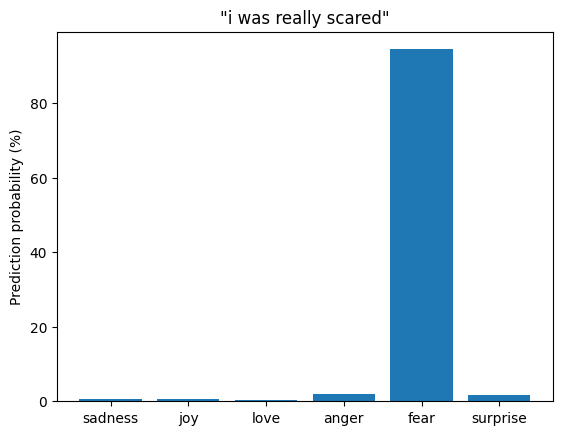

In [103]:
preds_df = pd.DataFrame(preds)
preds_df_sorted = preds_df.sort_values('label', ascending = True)
plt.bar(labels.names, 100 * preds_df_sorted['score'])
plt.title(f'"{tweet}"')
plt.ylabel('Prediction probability (%)')
plt.show()